In [16]:
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
from pathlib import Path as pt
cloud_path = pt(r'D:/DS\Weather Classification/dataset2/cloudy')
rain_path = pt(r'D:/DS\Weather Classification/dataset2/rainy')
shine_path = pt(r'D:/DS\Weather Classification/dataset2/sinshine')
rise_path = pt(r'D:/DS\Weather Classification/dataset2/sunrise')

In [3]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [4]:
cloud_df = generate_df(cloud_path, label="cloudy")
rainy_df = generate_df(rain_path, label="rainy")
shine_df = generate_df(shine_path, label='sunshine')
rise_df = generate_df(rise_path, label='sunrise')

all_df = pd.concat([cloud_df,rainy_df,shine_df,rise_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df.head()

,Filepath,Label
0,D:\DS\Weather Classification\dataset2\sunrise\...,sunrise
1,D:\DS\Weather Classification\dataset2\cloudy\c...,cloudy
2,D:\DS\Weather Classification\dataset2\sinshine...,sunshine
3,D:\DS\Weather Classification\dataset2\cloudy\c...,cloudy
4,D:\DS\Weather Classification\dataset2\cloudy\c...,cloudy


In [5]:
df = all_df.copy()

In [6]:
df.head()

,Filepath,Label
0,D:\DS\Weather Classification\dataset2\sunrise\...,sunrise
1,D:\DS\Weather Classification\dataset2\cloudy\c...,cloudy
2,D:\DS\Weather Classification\dataset2\sinshine...,sunshine
3,D:\DS\Weather Classification\dataset2\cloudy\c...,cloudy
4,D:\DS\Weather Classification\dataset2\cloudy\c...,cloudy


In [7]:
df.loc[0]

Filepath    D:\DS\Weather Classification\dataset2\sunrise\...
Label                                                 sunrise
Name: 0, dtype: object

In [8]:
df.shape

(1122, 2)

In [9]:
image_gen = ImageDataGenerator(rescale = 1./255,
                               validation_split = 0.2,
                               rotation_range = 45,
                               shear_range = 0.5,
                               horizontal_flip = True,
                               preprocessing_function = tf.keras.applications.resnet50.preprocess_input)

In [10]:
train_df, test_df = train_test_split(
    df.sample(1122, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [11]:
train_data = image_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = image_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = image_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    class_mode='sparse',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 628 validated image filenames belonging to 4 classes.
Found 157 validated image filenames belonging to 4 classes.
Found 337 validated image filenames belonging to 4 classes.


In [12]:
model = tf.keras.models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(120,120,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)

In [13]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(120, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
 dense_1 (Dense)             (None, 4)                 484       
                                                                 
Total params: 23,834,076
Trainable params: 246,364
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
history = model.fit(train_data,validation_data=val_data,epochs=50, callbacks = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience=5))

Epoch 1/50
20/20 [==============================] - 45s 2s/step - loss: 1.4928 - accuracy: 0.2898 - val_loss: 1.3877 - val_accuracy: 0.3185
Epoch 2/50
20/20 [==============================] - 35s 2s/step - loss: 1.3605 - accuracy: 0.3121 - val_loss: 1.3728 - val_accuracy: 0.3185
Epoch 3/50
20/20 [==============================] - 38s 2s/step - loss: 1.3628 - accuracy: 0.2803 - val_loss: 1.3910 - val_accuracy: 0.3185
Epoch 4/50
20/20 [==============================] - 39s 2s/step - loss: 1.3500 - accuracy: 0.3232 - val_loss: 1.3880 - val_accuracy: 0.3248
Epoch 5/50
20/20 [==============================] - 22s 1s/step - loss: 1.3391 - accuracy: 0.3312 - val_loss: 1.4408 - val_accuracy: 0.3121
Epoch 6/50
20/20 [==============================] - 17s 847ms/step - loss: 1.3481 - accuracy: 0.3201 - val_loss: 1.3667 - val_accuracy: 0.3185
Epoch 7/50
20/20 [==============================] - 17s 838ms/step - loss: 1.3363 - accuracy: 0.2978 - val_loss: 1.3520 - val_accuracy: 0.3312
Epoch 8/50
20/

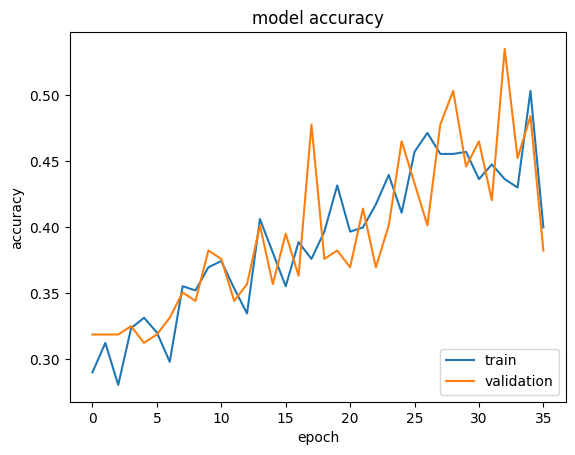

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

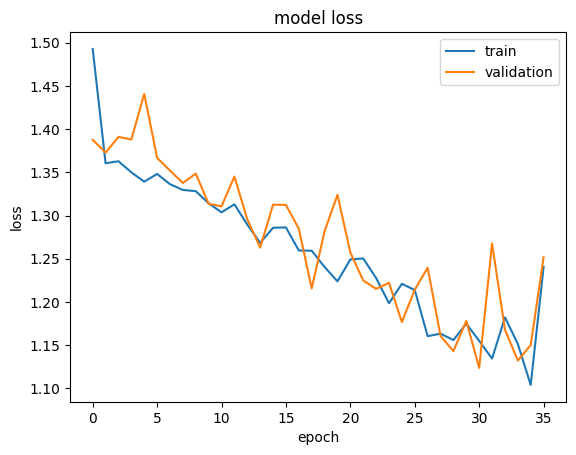

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [21]:
model.evaluate(test_data)

11/11 [==============================] - 16s 1s/step - loss: 1.2192 - accuracy: 0.4154


[1.219204068183899, 0.4154302775859833]